# Setup

## Libraries

In [1]:
# Data wrangling
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import PowerTransformer, OneHotEncoder

# Models
from prince import FAMD
from sklearn.cluster import KMeans

from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Models Pipelines
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate

# Serialize models
import pickle

In [2]:
# see rc Params on https://matplotlib.org/stable/tutorials/introductory/customizing.html
# or just take a look at plt.rcParams
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.labelpad': 20,
        'axes.titlepad': 30
    }
)

## Custom functions

In [3]:
def get_metrics(y_true, y_pred, y_proba=None):
    dict_metrics = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Balanced Accuracy': metrics.balanced_accuracy_score(y_true, y_pred),
        'Recall': metrics.recall_score(y_true, y_pred),
        'Precison': metrics.precision_score(y_true, y_pred),
        'F1': metrics.f1_score(y_true, y_pred),
    }
    
    if y_proba is not None:
        dict_metrics['ROC_AUC'] = metrics.roc_auc_score(y_true, y_proba)
    
    return dict_metrics

## Load dataset

In [4]:
NUMERIC_FEATURES = [
    # 'Latitude',
    # 'Longitude',
    'Tenure Months',
    'Monthly Charges',
    'Total Charges',
    'CLTV'
]

CATEGORICAL_FEATURES = [
    # 'Gender',
    'Senior Citizen',
    'Partner',
    'Dependents',
    # 'Phone Service',
    'Multiple Lines',
    'Internet Service',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Contract',
    'Paperless Billing',
    'Payment Method'
]

FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
TARGET = 'Churn'

In [5]:
df = pd.read_csv('../data/processed/customer_churn.csv', index_col='CustomerID', usecols=['CustomerID',*FEATURES,TARGET])
display(df)

,Senior Citizen,Partner,Dependents,Tenure Months,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,CLTV,Churn
CustomerID,,,,,,,,,,,,,,,,,,,
3668-QPYBK,No,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,3239,1
9237-HQITU,No,No,Yes,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,2701,1
9305-CDSKC,No,No,Yes,8,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,5372,1
7892-POOKP,No,Yes,Yes,28,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,5003,1
0280-XJGEX,No,No,Yes,49,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,5340,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569-WGERO,No,No,No,72,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,5306,0
6840-RESVB,No,Yes,Yes,24,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,2140,0
2234-XADUH,No,Yes,Yes,72,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,5560,0


In [6]:
# Verify target class distribution
df.Churn.value_counts(normalize=True)

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

# Modeling

In [7]:
X,y = df[FEATURES], df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=2023)

## Clustering

In [8]:
# Train cluster
cluster_pipeline = make_pipeline(
    make_column_transformer([FAMD(n_components=20), FEATURES]),
    KMeans(n_clusters=4, n_init='auto', random_state=2023)
)

# Add clusters
X_train['cluster'] = cluster_pipeline.fit_predict(X_train)
X_test['cluster'] = cluster_pipeline.predict(X_test)

## Prediction

In [9]:
# Model without handling unbalanced classes
preprocessor = make_column_transformer(
    (PowerTransformer(), NUMERIC_FEATURES),
    (OneHotEncoder(drop='if_binary'), CATEGORICAL_FEATURES) #+ ['cluster']
)

models = [
    LogisticRegressionCV(Cs=1_000, max_iter=1_000),
    SVC(random_state=2023),
    RandomForestClassifier(random_state=2023),
    CatBoostClassifier(random_state=2023, silent=True),
    DummyClassifier()
]

cv_results = []

for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    df_cv = pd.DataFrame(cross_validate(model_pipeline, X_train, y_train, scoring=['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1', 'roc_auc'], cv=5, n_jobs=-1))
    df_cv = df_cv.apply(lambda x: f'{x.mean():.2f} ± {x.std():.2f}').to_frame(model_name).T
    cv_results.append(df_cv)
    
df_cv_results = pd.concat(cv_results).sort_values('test_recall', ascending=False)
df_cv_results.columns = df_cv_results.columns.str.replace('test_','')
df_cv_results = df_cv_results.rename_axis('model')
display(df_cv_results)

LogisticRegressionCV
SVC
RandomForestClassifier
CatBoostClassifier
DummyClassifier


/home/cmcouto-silva/miniconda3/envs/telco-churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cmcouto-silva/miniconda3/envs/telco-churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cmcouto-silva/miniconda3/envs/telco-churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cmcouto-si

,fit_time,score_time,accuracy,balanced_accuracy,recall,precision,f1,roc_auc
model,,,,,,,,
LogisticRegressionCV,32.84 ± 0.76,0.03 ± 0.00,0.81 ± 0.01,0.72 ± 0.02,0.54 ± 0.03,0.68 ± 0.03,0.60 ± 0.03,0.85 ± 0.01
CatBoostClassifier,31.77 ± 0.07,0.13 ± 0.03,0.79 ± 0.01,0.71 ± 0.01,0.53 ± 0.03,0.64 ± 0.01,0.57 ± 0.02,0.85 ± 0.01
SVC,0.89 ± 0.02,0.44 ± 0.08,0.80 ± 0.02,0.70 ± 0.02,0.50 ± 0.03,0.66 ± 0.04,0.57 ± 0.03,0.82 ± 0.02
RandomForestClassifier,0.69 ± 0.08,0.11 ± 0.02,0.79 ± 0.02,0.69 ± 0.02,0.49 ± 0.03,0.63 ± 0.04,0.55 ± 0.03,0.83 ± 0.01
DummyClassifier,0.07 ± 0.02,0.05 ± 0.01,0.73 ± 0.00,0.50 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.50 ± 0.00


In [10]:
# Save result to excel
# df_cv_results.to_excel('../reports/tables/raw_metric.xlsx')

In [11]:
# Model handling unbalanced classes
preprocessor = make_column_transformer(
    (PowerTransformer(), NUMERIC_FEATURES),
    (OneHotEncoder(drop='if_binary'), CATEGORICAL_FEATURES) #+ ['cluster']
)

models = [
    LogisticRegressionCV(Cs=1_000, max_iter=1_000, class_weight='balanced'),
    SVC(class_weight='balanced', random_state=2023),
    RandomForestClassifier(random_state=2023, class_weight='balanced'),
    CatBoostClassifier(scale_pos_weight=3, random_state=2023, silent=True),
    DummyClassifier()
] 

cv_results = []

for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    df_cv = pd.DataFrame(cross_validate(model_pipeline, X_train, y_train, scoring=['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1', 'roc_auc'], cv=5, n_jobs=-1))
    df_cv = df_cv.apply(lambda x: f'{x.mean():.2f} ± {x.std():.2f}').to_frame(model_name).T
    cv_results.append(df_cv)
    
df_cv_results = pd.concat(cv_results).sort_values('test_recall', ascending=False)
df_cv_results.columns = df_cv_results.columns.str.replace('test_','')
df_cv_results = df_cv_results.rename_axis('model')
display(df_cv_results)

LogisticRegressionCV
SVC
RandomForestClassifier
CatBoostClassifier
DummyClassifier


/home/cmcouto-silva/miniconda3/envs/telco-churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cmcouto-silva/miniconda3/envs/telco-churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cmcouto-silva/miniconda3/envs/telco-churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cmcouto-si

,fit_time,score_time,accuracy,balanced_accuracy,recall,precision,f1,roc_auc
model,,,,,,,,
SVC,1.32 ± 0.05,0.49 ± 0.06,0.75 ± 0.00,0.77 ± 0.01,0.81 ± 0.03,0.52 ± 0.00,0.64 ± 0.01,0.84 ± 0.01
LogisticRegressionCV,35.64 ± 0.80,0.04 ± 0.01,0.76 ± 0.01,0.77 ± 0.02,0.79 ± 0.02,0.53 ± 0.02,0.64 ± 0.02,0.85 ± 0.01
CatBoostClassifier,31.49 ± 0.26,0.17 ± 0.09,0.77 ± 0.01,0.77 ± 0.02,0.77 ± 0.04,0.54 ± 0.01,0.64 ± 0.02,0.85 ± 0.01
RandomForestClassifier,0.88 ± 0.04,0.13 ± 0.01,0.78 ± 0.01,0.68 ± 0.01,0.47 ± 0.02,0.62 ± 0.03,0.54 ± 0.02,0.83 ± 0.01
DummyClassifier,0.09 ± 0.02,0.05 ± 0.01,0.73 ± 0.00,0.50 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.50 ± 0.00


In [12]:
# Save result to excel
# df_cv_results.to_excel('../reports/tables/metric_balanced.xlsx')

In [13]:
# Model handling unbalanced classes + clusters
preprocessor = make_column_transformer(
    (PowerTransformer(), NUMERIC_FEATURES),
    (OneHotEncoder(drop='if_binary'), CATEGORICAL_FEATURES + ['cluster'])
)

models = [
    LogisticRegressionCV(Cs=1_000, max_iter=1_000, class_weight='balanced'),
    RandomForestClassifier(random_state=2023, class_weight='balanced'),
    SVC(class_weight='balanced', random_state=2023),
    CatBoostClassifier(scale_pos_weight=3, random_state=2023, silent=True),
    DummyClassifier()
] 

cv_results = []

for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    df_cv = pd.DataFrame(cross_validate(model_pipeline, X_train, y_train, scoring=['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1', 'roc_auc'], cv=5, n_jobs=-1))
    df_cv = df_cv.apply(lambda x: f'{x.mean():.2f} ± {x.std():.2f}').to_frame(model_name).T
    cv_results.append(df_cv)
    
df_cv_results = pd.concat(cv_results).sort_values('test_recall', ascending=False)
df_cv_results.columns = df_cv_results.columns.str.replace('test_','')
df_cv_results = df_cv_results.rename_axis('model')
display(df_cv_results)

LogisticRegressionCV
RandomForestClassifier
SVC
CatBoostClassifier
DummyClassifier


/home/cmcouto-silva/miniconda3/envs/telco-churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cmcouto-silva/miniconda3/envs/telco-churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cmcouto-silva/miniconda3/envs/telco-churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cmcouto-si

,fit_time,score_time,accuracy,balanced_accuracy,recall,precision,f1,roc_auc
model,,,,,,,,
SVC,1.93 ± 0.04,0.64 ± 0.07,0.76 ± 0.01,0.77 ± 0.02,0.81 ± 0.03,0.53 ± 0.01,0.64 ± 0.02,0.84 ± 0.01
LogisticRegressionCV,38.80 ± 0.87,0.04 ± 0.01,0.76 ± 0.01,0.77 ± 0.02,0.79 ± 0.02,0.53 ± 0.02,0.63 ± 0.02,0.85 ± 0.01
CatBoostClassifier,37.03 ± 0.24,0.16 ± 0.07,0.77 ± 0.01,0.77 ± 0.02,0.76 ± 0.04,0.54 ± 0.01,0.63 ± 0.02,0.85 ± 0.01
RandomForestClassifier,0.90 ± 0.06,0.13 ± 0.01,0.79 ± 0.02,0.69 ± 0.02,0.48 ± 0.03,0.64 ± 0.04,0.55 ± 0.03,0.83 ± 0.01
DummyClassifier,0.08 ± 0.01,0.05 ± 0.01,0.73 ± 0.00,0.50 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.50 ± 0.00


In [14]:
# Save result to excel
# df_cv_results.to_excel('../reports/tables/metric_balanced_cluster.xlsx')

## Evaluation

In [15]:
# Set final preprocessor
preprocessor = ColumnTransformer([
    ('PowerTransformer', PowerTransformer(), NUMERIC_FEATURES),
    ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False), CATEGORICAL_FEATURES),
    ('onehot_clst', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['cluster'])
]).set_output(transform='pandas')

In [16]:
# Evaluate target three models in the final test set
lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegressionCV(Cs=1_000, max_iter=1_000, class_weight='balanced'))
])

svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(class_weight='balanced', random_state=2023))
])

catboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(scale_pos_weight=3, random_state=2023, silent=True))
])

In [17]:
# Logistic regression metrics
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]

lr_metrics = get_metrics(y_test, y_pred, y_proba)
lr_metrics

{'Accuracy': 0.7772511848341233,
 'Balanced Accuracy': 0.7937154555466179,
 'Recall': 0.8288770053475936,
 'Precison': 0.5542312276519666,
 'F1': 0.6642857142857144,
 'ROC_AUC': 0.869917801030853}

In [18]:
# Support vector classifier metrics
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

svc_metrics = get_metrics(y_test, y_pred)
svc_metrics

{'Accuracy': 0.7587677725118483,
 'Balanced Accuracy': 0.7777158283936851,
 'Recall': 0.8181818181818182,
 'Precison': 0.5300230946882217,
 'F1': 0.6433076384022425}

In [19]:
# Catboost metrics
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
y_proba = catboost.predict_proba(X_test)[:,1]

catboost_metrics = get_metrics(y_test, y_pred, y_proba)
catboost_metrics

{'Accuracy': 0.7772511848341233,
 'Balanced Accuracy': 0.7846198283292424,
 'Recall': 0.8003565062388592,
 'Precison': 0.5563816604708798,
 'F1': 0.6564327485380117,
 'ROC_AUC': 0.8645207246581947}

In [20]:
# Display final metrics
df_metrics = pd.DataFrame([lr_metrics,svc_metrics,catboost_metrics], index=['Logistic Regression', 'SVC', 'CatBoost']).sort_values('Recall', ascending=False)
display(df_metrics)

,Accuracy,Balanced Accuracy,Recall,Precison,F1,ROC_AUC
Logistic Regression,0.777251,0.793715,0.828877,0.554231,0.664286,0.869918
SVC,0.758768,0.777716,0.818182,0.530023,0.643308,NaN
CatBoost,0.777251,0.784620,0.800357,0.556382,0.656433,0.864521


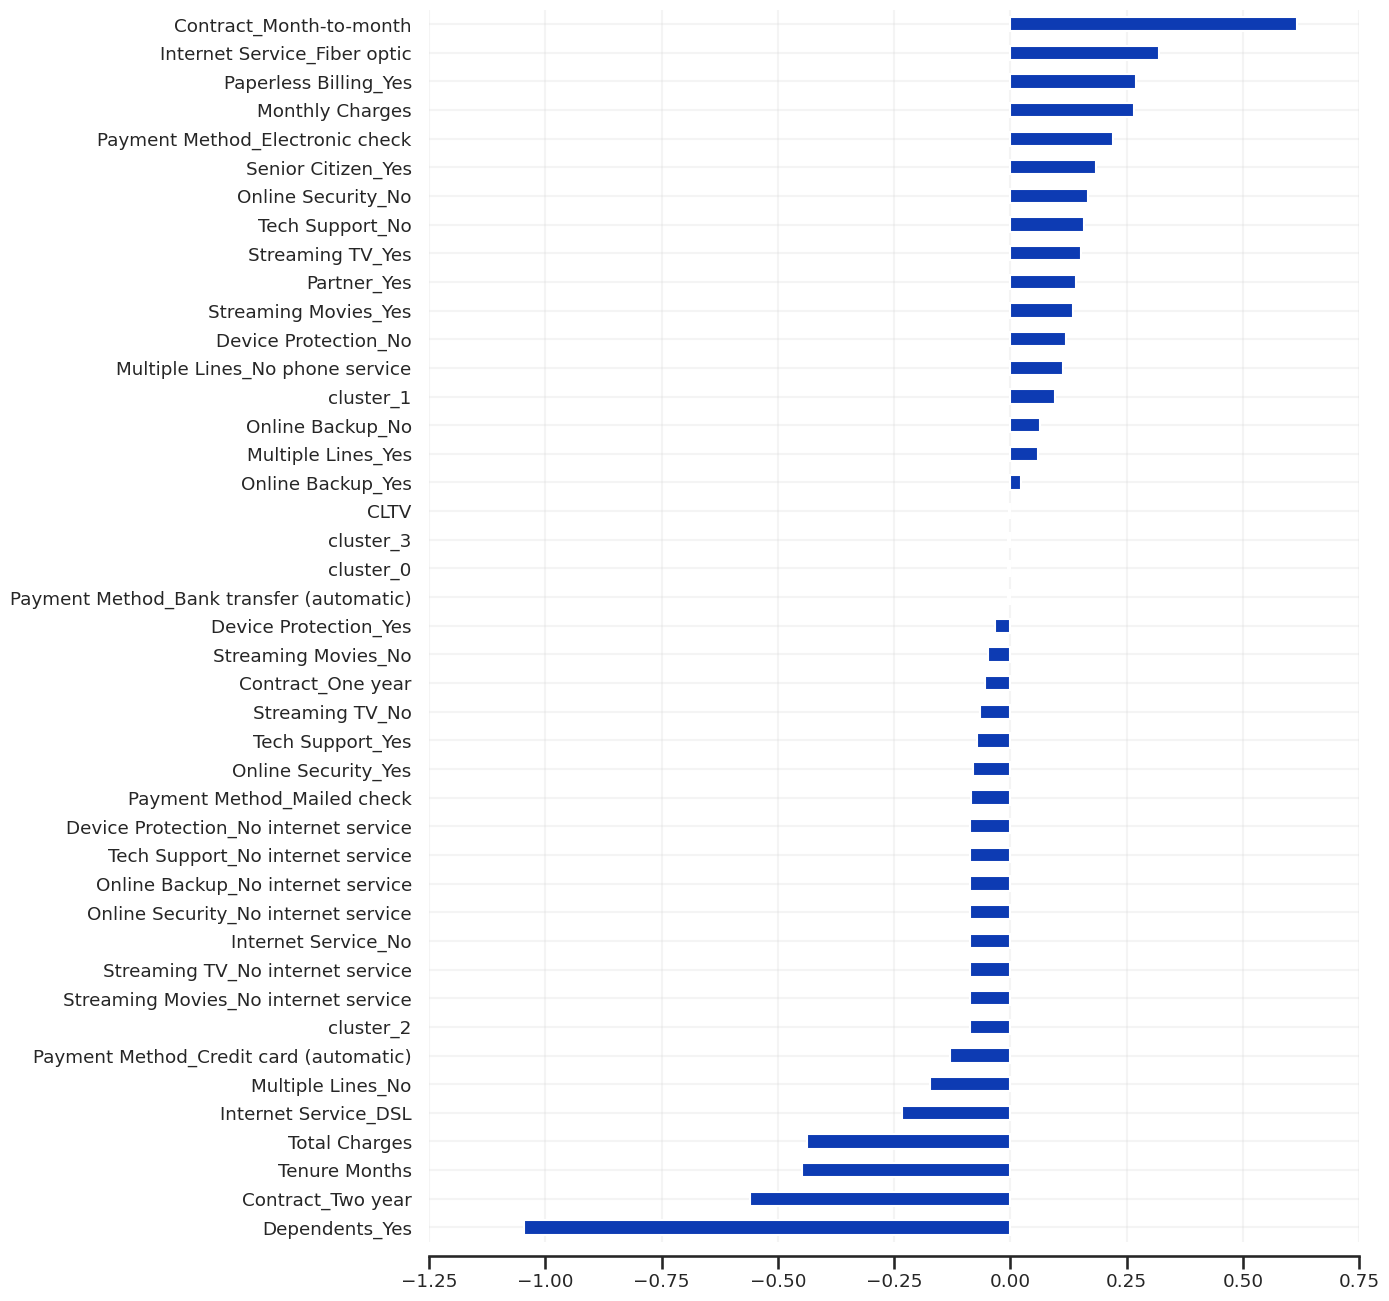

In [21]:
lr_model = lr.named_steps['model']

coefs = pd.Series(
    data=lr_model.coef_[0],
    index=[feature.split('__')[1] for feature in lr_model.feature_names_in_]
)

plt.figure(figsize=(12,16))
coefs.sort_values().plot.barh(color='#0d3bb3')
plt.tick_params(left = False)
plt.xlim(-1.25, 0.75)
sns.despine(left=True, offset=10, trim=True)
plt.show()

## Saving models

In [22]:
# churn_pipeline = lr

In [23]:
# with open('../models/cluster_pipeline.pkl', 'wb') as file:
#     pickle.dump(cluster_pipeline, file)

In [24]:
# with open('../models/prediction_pipeline.pkl', 'wb') as file:
#     pickle.dump(churn_pipeline, file)